# Understanding YOLO Output

## Yolo output have 3 scale and each scale have 3 anchor
(x,y, (anchor*5+class) )
(x,y,anchor,5+class) 5 - > consist of (x,y,w,h,conf)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.yolo3 import yolo_body, tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

Using TensorFlow backend.


In [3]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [4]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model,new_model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            #if i==0:
            #    print("random")
            #    np.random.shuffle(annotation_lines)
            print(annotation_lines[i])
            image, box = get_random_data(annotation_lines[i], input_shape, random=False)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = new_model.predict(image_data)
        om_true = model.predict(image_data) 

        yield image_data , box_data , y_true , m_true , om_true #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model,new_model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model,new_model)

In [5]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_weights_final.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


new_model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1

#train_lines

In [6]:
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

batch_size = 1

image = {}
box = {}
train_logits = {}
model_logits = {}

datagen = data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model,new_model)

D:\FinalProject\ComputerVision\yolov3_keras/VOCdevkit/VOC2007/JPEGImages/000012.jpg 156,97,351,270,6



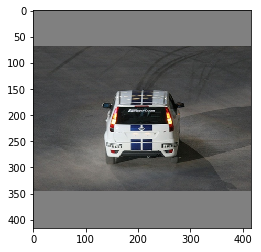

In [7]:
img,box_data,flogits,mlogits,omlogits = next(datagen)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(img[0])
plt.show()

In [8]:
flogits[0].shape

(1, 13, 13, 3, 25)

In [9]:
np.set_printoptions(threshold=np.inf)

In [10]:
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))#13 
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))#416
    
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        
        print("grid-------------")
        print( grid.eval() )
        print( K.sigmoid(feats[..., :2]).eval().shape )
        print( grid.eval().shape )
        print("-------------")
        print( K.cast(grid_shape[::-1], K.dtype(feats)).eval() )
        print("anchor-------------")
        print( anchors_tensor.eval() )
        print( K.exp(feats[..., 2:4]).shape )
        print( anchors_tensor.eval().shape )
        print("-------------")
        print( K.cast(input_shape[::-1], K.dtype(feats)).eval() )
      
    
    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs



In [11]:
import math
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

def sigmoid(x):
        """sigmoid.

        # Arguments
            x: Tensor.

        # Returns
            numpy ndarray.
        """
        return 1 / (1 + np.exp(-x))
    

### Real Dataset

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [12]:
arrpfake = flogits[0]
boxfake = np.where(arrpfake[...,4] > 0 )
boxfake = np.transpose(boxfake)
boxfake

array([[0, 6, 6, 1]], dtype=int64)

x,y,w,h,p and class

In [13]:
box = boxfake
arrp= arrpfake
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")

([0 6 6 1])
[0.5048077  0.53125    0.39182693 0.34615386 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------


### Model Predict

In [14]:
arrpmod = mlogits[0]
boxmod = np.where(arrpmod[...,4] > 0.3 )
boxmod = np.transpose(boxmod)
boxmod

array([[0, 6, 6, 1],
       [0, 7, 6, 0],
       [0, 7, 6, 1]], dtype=int64)

In [15]:
box = boxmod
arrp= arrpmod
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")

([0 6 6 1])
[-8.2986824e-02  2.1424468e+00 -3.6747069e-03 -3.7226868e-01
  5.1177735e+00]
[-11.157658  -12.421956  -13.663926  -10.056616  -10.029309  -10.689844
   8.980825  -10.991217  -10.011401   -9.582724  -10.9943495 -13.566522
 -10.219558  -11.941319  -13.75823   -10.97457   -10.821873  -10.105441
 -11.609203  -10.489247 ]
6 = car
-------------------------------------------------------
([0 7 6 0])
[ 0.09616603 -1.547877    0.25036636  0.24787842  2.1586404 ]
[-12.956437  -12.396319  -13.31427   -14.990557  -12.009419   -9.727695
   9.311118  -13.634066  -11.863196   -8.065649  -10.196227  -13.985082
 -12.846802  -10.089027  -11.65653   -13.502928  -12.449015   -8.7880745
  -9.16934   -11.347376 ]
6 = car
-------------------------------------------------------
([0 7 6 1])
[-0.09645594 -2.2636325   0.02756734 -0.3849751   6.7863197 ]
[-10.896839  -11.665582  -13.499608  -12.4512005  -9.218515  -10.42707
   8.923672  -11.689989  -12.479529   -9.714804  -10.301623  -13.107307
 -12.1

x,y,w,h,p and class

Combined Box

In [16]:
box_xy = sigmoid(mlogits[0][...,:2])
box_wh = np.exp(mlogits[0][..., 2:4])
box_confidence = sigmoid(mlogits[0][..., 4])
box_class_probs = sigmoid(mlogits[0][..., 5:])
box_class_probs 

array([[[[[1.42302304e-06, 5.96692378e-04, 1.38178086e-06,
           4.15689840e-07, 2.38812245e-05, 2.35377171e-04,
           2.55891991e-05, 2.77234794e-05, 5.38709536e-02,
           1.71931297e-05, 4.03382046e-06, 1.62334925e-06,
           4.15927316e-05, 1.05694226e-05, 2.59046089e-02,
           5.74217893e-06, 1.24535509e-05, 5.59449745e-06,
           2.72706575e-06, 5.26573451e-04],
          [1.43144835e-05, 6.66253269e-04, 2.79955093e-05,
           1.60337962e-07, 1.22681595e-04, 3.17559097e-05,
           8.00001453e-06, 7.91352613e-06, 4.42352239e-03,
           3.25753763e-06, 4.72949941e-05, 5.63412414e-06,
           9.06790945e-07, 4.82721634e-06, 4.91638064e-01,
           9.52985999e-07, 5.56578129e-07, 1.88862818e-04,
           1.25961660e-05, 3.80561542e-05],
          [7.91668717e-05, 9.31969844e-03, 4.17115807e-05,
           8.20788409e-05, 3.84420273e-05, 3.49484594e-03,
           9.11208708e-03, 7.17799994e-05, 2.36531720e-04,
           8.12370217e-06, 

In [17]:
newa = np.copy(mlogits[0])
newa[...,:2] = box_xy 
newa[..., 2:4] = box_wh
newa[..., 4] = box_confidence
newa[..., 5:] = box_class_probs
newa[..., 5:]

array([[[[[1.42302304e-06, 5.96692378e-04, 1.38178086e-06,
           4.15689840e-07, 2.38812245e-05, 2.35377171e-04,
           2.55891991e-05, 2.77234794e-05, 5.38709536e-02,
           1.71931297e-05, 4.03382046e-06, 1.62334925e-06,
           4.15927316e-05, 1.05694226e-05, 2.59046089e-02,
           5.74217893e-06, 1.24535509e-05, 5.59449745e-06,
           2.72706575e-06, 5.26573451e-04],
          [1.43144835e-05, 6.66253269e-04, 2.79955093e-05,
           1.60337962e-07, 1.22681595e-04, 3.17559097e-05,
           8.00001453e-06, 7.91352613e-06, 4.42352239e-03,
           3.25753763e-06, 4.72949941e-05, 5.63412414e-06,
           9.06790945e-07, 4.82721634e-06, 4.91638064e-01,
           9.52985999e-07, 5.56578129e-07, 1.88862818e-04,
           1.25961660e-05, 3.80561542e-05],
          [7.91668717e-05, 9.31969844e-03, 4.17115807e-05,
           8.20788409e-05, 3.84420273e-05, 3.49484594e-03,
           9.11208708e-03, 7.17799994e-05, 2.36531720e-04,
           8.12370217e-06, 

In [18]:
arrpcom = newa
boxcom = np.where(arrpcom[...,4] > 0.5 )
boxcom = np.transpose(boxcom)
boxcom

array([[0, 6, 6, 1],
       [0, 7, 6, 0],
       [0, 7, 6, 1]], dtype=int64)

In [19]:
box = boxcom
arrp= arrpcom
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( arrp[tuple(box[i])][0:5] )
    print( arrp[tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")

([0 6 6 1])
[0.4792652  0.8949609  0.99633205 0.68916905 0.99404633]
[1.4265423e-05 4.0291297e-06 1.1636752e-06 4.2899141e-05 4.4086657e-05
 2.2774548e-05 9.9987423e-01 1.6848759e-05 4.4883240e-05 6.8904257e-05
 1.6796059e-05 1.2827262e-06 3.6449084e-05 6.5155041e-06 1.0589515e-06
 1.7131573e-05 1.9957757e-05 4.0854975e-05 9.0820331e-06 2.7833363e-05]
6 = car
-------------------------------------------------------
([0 7 6 0])
[0.524023   0.17539312 1.284496   1.2813041  0.89647347]
[2.3609666e-06 4.1337585e-06 1.6507652e-06 3.0880463e-07 6.0865718e-06
 5.9605954e-05 9.9990964e-01 1.1989471e-06 7.0449223e-06 3.1404849e-04
 3.7309434e-05 8.4402598e-07 2.6345338e-06 4.1531061e-05 8.6622240e-06
 1.3669493e-06 3.9215697e-06 1.5251814e-04 1.0417438e-04 1.1800276e-05]
6 = car
-------------------------------------------------------
([0 7 6 1])
[0.47590467 0.09418002 1.0279509  0.6804676  0.9988721 ]
[1.8516328e-05 8.5841739e-06 1.3714947e-06 3.9130068e-06 9.9175995e-05
 2.9618859e-05 9.9986684

real complete formula

In [20]:
import tensorflow as tf

pred_output = tf.Variable(omlogits[0]) 
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] 

pred_xy, pred_wh , pred_conf , pred_class = yolo_head( pred_output ,anchors[anchor_mask[0]], num_classes, input_shape, calc_loss=False)
pred_box = K.concatenate([pred_xy, pred_wh])


#convert tf variable to real varable
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    pred_box = pred_box.eval()
    pred_conf = pred_conf.eval()
    pred_class = pred_class.eval()

grid-------------
[[[[ 0.  0.]]

  [[ 1.  0.]]

  [[ 2.  0.]]

  [[ 3.  0.]]

  [[ 4.  0.]]

  [[ 5.  0.]]

  [[ 6.  0.]]

  [[ 7.  0.]]

  [[ 8.  0.]]

  [[ 9.  0.]]

  [[10.  0.]]

  [[11.  0.]]

  [[12.  0.]]]


 [[[ 0.  1.]]

  [[ 1.  1.]]

  [[ 2.  1.]]

  [[ 3.  1.]]

  [[ 4.  1.]]

  [[ 5.  1.]]

  [[ 6.  1.]]

  [[ 7.  1.]]

  [[ 8.  1.]]

  [[ 9.  1.]]

  [[10.  1.]]

  [[11.  1.]]

  [[12.  1.]]]


 [[[ 0.  2.]]

  [[ 1.  2.]]

  [[ 2.  2.]]

  [[ 3.  2.]]

  [[ 4.  2.]]

  [[ 5.  2.]]

  [[ 6.  2.]]

  [[ 7.  2.]]

  [[ 8.  2.]]

  [[ 9.  2.]]

  [[10.  2.]]

  [[11.  2.]]

  [[12.  2.]]]


 [[[ 0.  3.]]

  [[ 1.  3.]]

  [[ 2.  3.]]

  [[ 3.  3.]]

  [[ 4.  3.]]

  [[ 5.  3.]]

  [[ 6.  3.]]

  [[ 7.  3.]]

  [[ 8.  3.]]

  [[ 9.  3.]]

  [[10.  3.]]

  [[11.  3.]]

  [[12.  3.]]]


 [[[ 0.  4.]]

  [[ 1.  4.]]

  [[ 2.  4.]]

  [[ 3.  4.]]

  [[ 4.  4.]]

  [[ 5.  4.]]

  [[ 6.  4.]]

  [[ 7.  4.]]

  [[ 8.  4.]]

  [[ 9.  4.]]

  [[10.  4.]]

  [[11.  4.]]

  [[12.  4.]]]

In [21]:
newb = np.copy(mlogits[0])
newb[...,:4] = pred_box
newb[..., 4:5] = pred_conf
newb[..., 5:] = pred_class
newb[..., 5:]

array([[[[[1.42302304e-06, 5.96692378e-04, 1.38178086e-06,
           4.15689840e-07, 2.38812245e-05, 2.35377171e-04,
           2.55891991e-05, 2.77234794e-05, 5.38709573e-02,
           1.71931297e-05, 4.03382046e-06, 1.62334925e-06,
           4.15927352e-05, 1.05694226e-05, 2.59046089e-02,
           5.74217938e-06, 1.24535509e-05, 5.59449745e-06,
           2.72706575e-06, 5.26573451e-04],
          [1.43144835e-05, 6.66253269e-04, 2.79955093e-05,
           1.60337962e-07, 1.22681595e-04, 3.17559097e-05,
           8.00001453e-06, 7.91352613e-06, 4.42352239e-03,
           3.25753717e-06, 4.72949941e-05, 5.63412414e-06,
           9.06790945e-07, 4.82721634e-06, 4.91638064e-01,
           9.52985999e-07, 5.56578129e-07, 1.88862818e-04,
           1.25961660e-05, 3.80561505e-05],
          [7.91668790e-05, 9.31969844e-03, 4.17115807e-05,
           8.20788409e-05, 3.84420273e-05, 3.49484594e-03,
           9.11208708e-03, 7.17799994e-05, 2.36531720e-04,
           8.12370217e-06, 

recreated complete formula

In [31]:
anchors_tensor = np.reshape( anchors[anchor_mask[0]] , [1, 1, 1,len( anchors[anchor_mask[0]] ) , 2] )
anchors_tensor.shape

(1, 1, 1, 3, 2)

In [44]:
grid_shape = mlogits[0].shape[1:3] # height, width
grid_shape
grid_y = np.tile(np.reshape(np.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
    [1, grid_shape[1], 1, 1])
grid_x = np.tile(np.reshape(np.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
    [grid_shape[0], 1, 1, 1])
grid = np.concatenate([grid_x, grid_y],axis=-1)
grid

array([[[[ 0,  0]],

        [[ 1,  0]],

        [[ 2,  0]],

        [[ 3,  0]],

        [[ 4,  0]],

        [[ 5,  0]],

        [[ 6,  0]],

        [[ 7,  0]],

        [[ 8,  0]],

        [[ 9,  0]],

        [[10,  0]],

        [[11,  0]],

        [[12,  0]]],


       [[[ 0,  1]],

        [[ 1,  1]],

        [[ 2,  1]],

        [[ 3,  1]],

        [[ 4,  1]],

        [[ 5,  1]],

        [[ 6,  1]],

        [[ 7,  1]],

        [[ 8,  1]],

        [[ 9,  1]],

        [[10,  1]],

        [[11,  1]],

        [[12,  1]]],


       [[[ 0,  2]],

        [[ 1,  2]],

        [[ 2,  2]],

        [[ 3,  2]],

        [[ 4,  2]],

        [[ 5,  2]],

        [[ 6,  2]],

        [[ 7,  2]],

        [[ 8,  2]],

        [[ 9,  2]],

        [[10,  2]],

        [[11,  2]],

        [[12,  2]]],


       [[[ 0,  3]],

        [[ 1,  3]],

        [[ 2,  3]],

        [[ 3,  3]],

        [[ 4,  3]],

        [[ 5,  3]],

        [[ 6,  3]],

        [[ 7,  3]],

       

In [24]:
np.array( grid_shape[::-1] )

array([13, 13])

In [25]:
np.array( input_shape[::-1] )

array([416, 416])

In [26]:
box_xy = ( sigmoid(mlogits[0][...,:2])+ grid ) / np.array( grid_shape[::-1] )
box_wh = np.exp(mlogits[0][..., 2:4]) * anchors_tensor / np.array( input_shape[::-1] )
box_confidence = sigmoid(mlogits[0][..., 4])
box_class_probs = sigmoid(mlogits[0][..., 5:])

In [36]:
np.exp(mlogits[0][..., 2:4]).shape

(1, 13, 13, 3, 2)

In [35]:
anchors_tensor.shape

(1, 1, 1, 3, 2)

In [34]:
np.exp(mlogits[0][..., 2:4])* anchors_tensor 

array([[[[[109.095783  , 118.07280421],
          [123.65415072, 262.61340022],
          [393.78292692, 331.54983711]],

         [[125.97993708, 112.94902325],
          [149.33134389, 335.98233104],
          [255.29488122, 368.21938086]],

         [[134.75129652, 104.75883365],
          [157.03858566, 282.9353478 ],
          [283.10860199, 236.0217191 ]],

         [[145.37543774, 141.73120737],
          [163.19619656, 283.23121691],
          [274.00809276, 275.80717802]],

         [[170.98110723, 197.40002632],
          [180.98091602, 277.45599818],
          [272.0044747 , 250.09330451]],

         [[195.75316668, 182.54151106],
          [188.24735212, 255.02838778],
          [308.18856609, 252.74883831]],

         [[206.56194305, 186.19055986],
          [202.24140501, 242.20747161],
          [289.16939044, 227.61579967]],

         [[220.85399342, 191.8609643 ],
          [206.22118092, 238.115839  ],
          [315.98515952, 246.14210403]],

         [[224.59822083,

In [27]:
newa2 = np.copy(mlogits[0])
newa2[...,:2] = box_xy 
newa2[..., 2:4] = box_wh
newa2[..., 4] = box_confidence
newa2[..., 5:] = box_class_probs
newa2[..., 5:]

array([[[[[1.42302304e-06, 5.96692378e-04, 1.38178086e-06,
           4.15689840e-07, 2.38812245e-05, 2.35377171e-04,
           2.55891991e-05, 2.77234794e-05, 5.38709536e-02,
           1.71931297e-05, 4.03382046e-06, 1.62334925e-06,
           4.15927316e-05, 1.05694226e-05, 2.59046089e-02,
           5.74217893e-06, 1.24535509e-05, 5.59449745e-06,
           2.72706575e-06, 5.26573451e-04],
          [1.43144835e-05, 6.66253269e-04, 2.79955093e-05,
           1.60337962e-07, 1.22681595e-04, 3.17559097e-05,
           8.00001453e-06, 7.91352613e-06, 4.42352239e-03,
           3.25753763e-06, 4.72949941e-05, 5.63412414e-06,
           9.06790945e-07, 4.82721634e-06, 4.91638064e-01,
           9.52985999e-07, 5.56578129e-07, 1.88862818e-04,
           1.25961660e-05, 3.80561542e-05],
          [7.91668717e-05, 9.31969844e-03, 4.17115807e-05,
           8.20788409e-05, 3.84420273e-05, 3.49484594e-03,
           9.11208708e-03, 7.17799994e-05, 2.36531720e-04,
           8.12370217e-06, 

ALL

In [28]:
arrpall = flogits[0]
boxall = np.where(arrpall[...,4] > 0 )
boxall = np.transpose(boxall)
boxall

array([[0, 6, 6, 1]], dtype=int64)

In [29]:
box = boxall
arrp= arrpall
for i in range(len(box)):

    print( "({})".format(box[i]) )
    print( "true" )
    print( flogits[0][tuple(box[i])][0:5] )
    print( flogits[0][tuple(box[i])][5:25] )
    true_label =  np.argmax( arrp[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "pure model" )
    print( mlogits[0][tuple(box[i])][0:5] )
    print( mlogits[0][tuple(box[i])][5:25] )
    true_label =  np.argmax( mlogits[0][tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "modified half" )
    print( newa[tuple(box[i])][0:5] )
    print( newa[tuple(box[i])][5:25] )
    true_label =  np.argmax( newa[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "modified full" )
    print( newa2[tuple(box[i])][0:5] )
    print( newa2[tuple(box[i])][5:25] )
    true_label =  np.argmax( newa2[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("-------------------------------------------------------")
    print( "({})".format(box[i]) )
    print( "real modified" )
    print( newb[tuple(box[i])][0:5] )
    print( newb[tuple(box[i])][5:25] )
    true_label =  np.argmax( newb[tuple(box[i])][5:25]) 
    print( "{} = {}".format(true_label, obj[ true_label ] ) )
    print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

([0 6 6 1])
true
[0.5048077  0.53125    0.39182693 0.34615386 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------
([0 6 6 1])
pure model
[-8.2986824e-02  2.1424468e+00 -3.6747069e-03 -3.7226868e-01
  5.1177735e+00]
[-11.157658  -12.421956  -13.663926  -10.056616  -10.029309  -10.689844
   8.980825  -10.991217  -10.011401   -9.582724  -10.9943495 -13.566522
 -10.219558  -11.941319  -13.75823   -10.97457   -10.821873  -10.105441
 -11.609203  -10.489247 ]
6 = car
-------------------------------------------------------
([0 6 6 1])
modified half
[0.4792652  0.8949609  0.99633205 0.68916905 0.99404633]
[1.4265423e-05 4.0291297e-06 1.1636752e-06 4.2899141e-05 4.4086657e-05
 2.2774548e-05 9.9987423e-01 1.6848759e-05 4.4883240e-05 6.8904257e-05
 1.6796059e-05 1.2827262e-06 3.6449084e-05 6.5155041e-06 1.0589515e-06
 1.7131573e-05 1.9957757e-05 4.0854975e-05 9.0820331e-06 2.7833363e-05]
6 = car
-----------------

In [30]:
b = np.array([[0.5,0.5,0.5],[0.3,0.3,0.3],[0.1,0.2,0.3]])
b

array([[0.5, 0.5, 0.5],
       [0.3, 0.3, 0.3],
       [0.1, 0.2, 0.3]])

In [22]:
b.shape

(3, 3)

In [23]:
c =  sigmoid(b)
c

array([[0.62245933, 0.62245933, 0.62245933],
       [0.57444252, 0.57444252, 0.57444252],
       [0.52497919, 0.549834  , 0.57444252]])

In [24]:
x =  sigmoid(b[...,1])
x

array([0.62245933, 0.57444252, 0.549834  ])

In [25]:
c[1]

array([0.57444252, 0.57444252, 0.57444252])

In [26]:
a = np.copy(b)
a

array([[0.5, 0.5, 0.5],
       [0.3, 0.3, 0.3],
       [0.1, 0.2, 0.3]])

In [27]:
a[...,1]=c[...,1]
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])

In [28]:
g = c[...,1]
g

array([0.62245933, 0.57444252, 0.549834  ])

In [29]:
a[...,1] = g
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])

In [30]:
a[...,1] = x
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])

In [31]:
b

array([[0.5, 0.5, 0.5],
       [0.3, 0.3, 0.3],
       [0.1, 0.2, 0.3]])

In [32]:
a

array([[0.5       , 0.62245933, 0.5       ],
       [0.3       , 0.57444252, 0.3       ],
       [0.1       , 0.549834  , 0.3       ]])